In [1]:
from skimage import feature, io, color, util, segmentation, transform, draw, img_as_ubyte, img_as_float, measure, img_as_bool, filters
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from scipy import optimize
from skimage.morphology import disk, dilation, erosion, square, closing
from scipy import ndimage as ndi

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage.restoration import denoise_bilateral, estimate_sigma
from skimage import segmentation, exposure, morphology

In [176]:
# Load image

# Images:
# Filename shape color bg shadow
# !0BRS2FMA6I4SWH!4_5NF1STHG!LPH.JPG oval brown noisy soft
# !0X7C0H7OX3J65RAO-1-1HH7NPH6K2.JPG round yellow clean soft
# !!F9BRW_A7W0FZYX-Q315LI_6RYIWS.JPG oval white clean soft
# !4-7H80OESB!RLZ6N9NZ7H82B2FMBU.JPG oval purple clean soft
# !!Q_XS3RZCK1M78NMERKUB!84!TETO.JPG capsule purple noise soft
# !1HWBQDYM5JD9CEJT6O0F8VD3IRSH_.PNG triangle white clear none
images_dir = 'Dataset/consumer'
filenames = [
    '!0BRS2FMA6I4SWH!4_5NF1STHG!LPH.JPG',
    '!0X7C0H7OX3J65RAO-1-1HH7NPH6K2.JPG',
    '!!F9BRW_A7W0FZYX-Q315LI_6RYIWS.JPG',
    '!4-7H80OESB!RLZ6N9NZ7H82B2FMBU.JPG',
    '!!Q_XS3RZCK1M78NMERKUB!84!TETO.JPG',
    '!1HWBQDYM5JD9CEJT6O0F8VD3IRSH_.PNG',
]
filename = filenames[5]

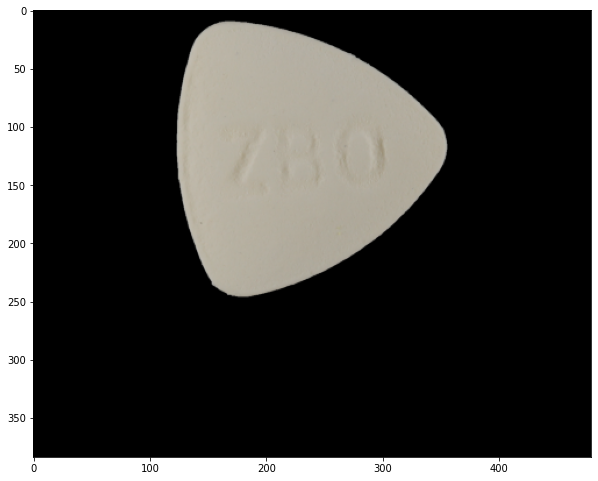

In [177]:
image_orig = io.imread(os.path.join(images_dir, filename))
if image_orig.shape[-1] == 4:
    image_orig = image_orig[:,:,:3]

def crop_center(img):
    y,x,d = img.shape
    cropx = int(x * 0.5)
    cropy = int(y * 0.5)
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]
    
image = crop_center(image_orig)
image = transform.resize(image, (int(image.shape[0] * (480 / image.shape[1])), 480), anti_aliasing=True)
# Resize
# image = transform.resize(image_orig, (int(image_orig.shape[0] * (480 / image_orig.shape[1])), 480), anti_aliasing=True)
plt.figure(figsize=(10,10))
plt.imshow(image)

Estimated Gaussian noise standard deviation = 0.0019096221579009982


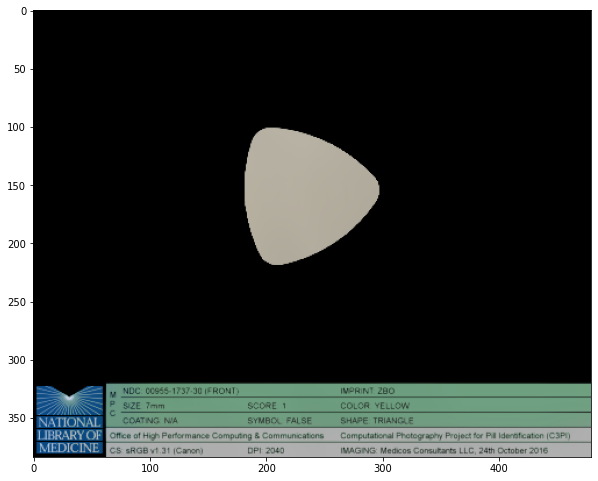

In [69]:
# Bilateral filter

sigma_est = estimate_sigma(image, multichannel=True, average_sigmas=True)

print(f"Estimated Gaussian noise standard deviation = {sigma_est}")
bilat = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, multichannel=True)

plt.figure(figsize=(10,10))
plt.imshow(bilat)

/home/mirko/Envs/pill-classification/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


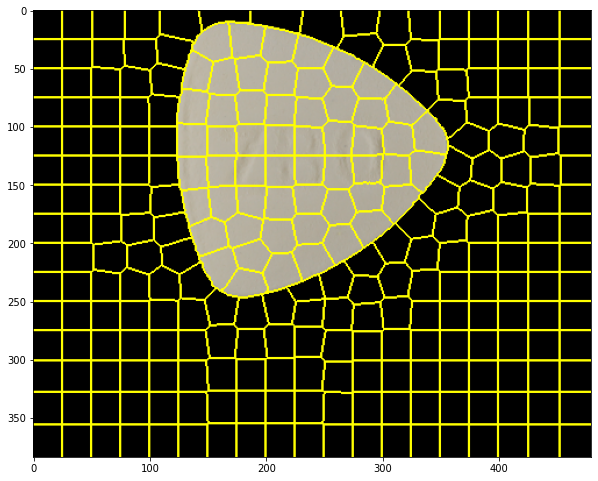

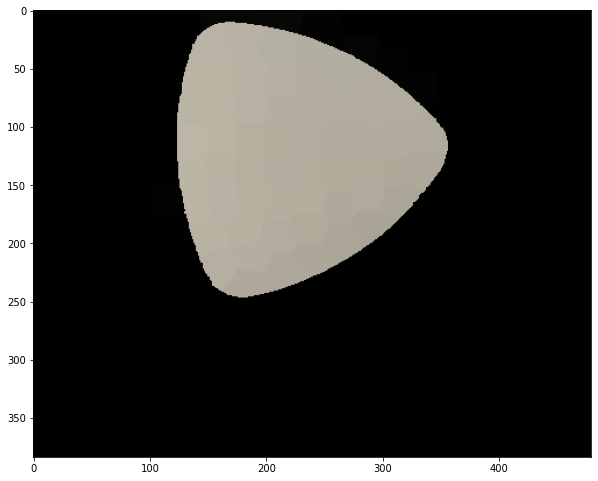

In [178]:
# SLIC

img = util.img_as_float(image)
img_slic = segmentation.slic(img, n_segments=300, compactness=13, sigma=0.5, start_label=1)

plt.figure(figsize=(10,10))

plt.imshow(segmentation.mark_boundaries(img, img_slic))

regions = regionprops(img_slic)
label_rgb = color.label2rgb(img_slic, img, kind='avg')

plt.figure(figsize=(10,10))

plt.imshow(label_rgb)

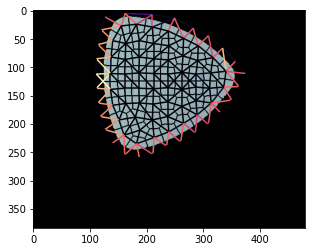

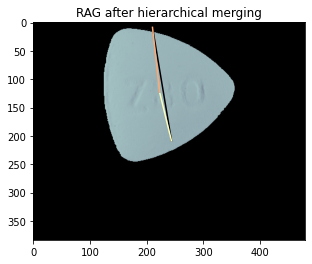

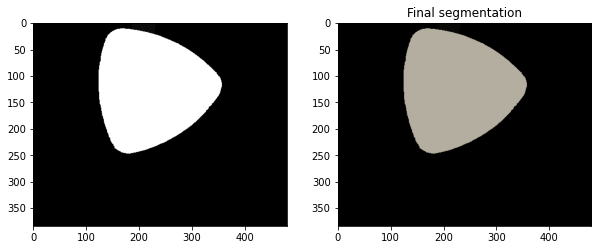

In [179]:
from skimage.future import graph
# rag = graph.rag_mean_color(img, img_slic)

def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


edges = filters.sobel(color.rgb2gray(img))


# rag = graph.rag_mean_color(img, img_slic)

rag = graph.rag_boundary(img_slic, img_as_float(edges))

graph.show_rag(img_slic, rag, img)

# labels2 = graph.cut_normalized(img_slic, rag)

labels2 = graph.merge_hierarchical(img_slic, rag, thresh=0.03, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

#labels2 = graph.merge_hierarchical(img_slic, rag, thresh=0.03, rag_copy=False,
#                                   in_place_merge=True,
#                                   merge_func=merge_mean_color,
#                                   weight_func=_weight_mean_color)

# labels2 = graph.cut_threshold(img_slic, rag, 29)

graph.show_rag(img_slic, rag, img)
plt.title('RAG after hierarchical merging')

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(color.rgb2gray(out), cmap='gray')
ax[1].imshow(out, cmap='gray')
plt.title('Final segmentation')

plt.show()

0.0013350995287132563


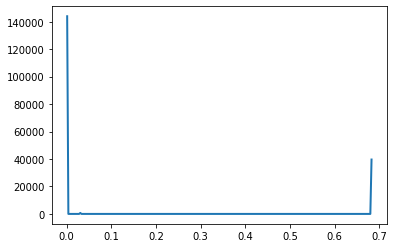

In [180]:
hist, hist_centers = exposure.histogram(color.rgb2gray(out))

plt.plot(hist_centers, hist, lw=2)

print(hist_centers[np.argmax(hist)])

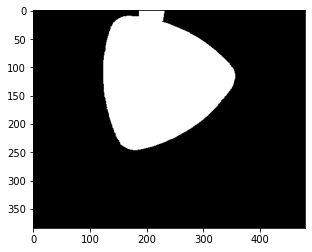

In [192]:
out1 = color.rgb2gray(out).copy()
thresh = hist_centers[np.argmax(hist)]
idx = out1 <= thresh
iidx = out1 > thresh
bg_color = False if len(idx) > len(iidx) else True
out1[idx] = not bg_color
out1[iidx] = bg_color

plt.imshow(out1, cmap='gray')

1


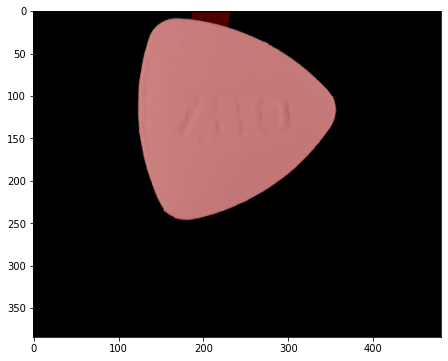

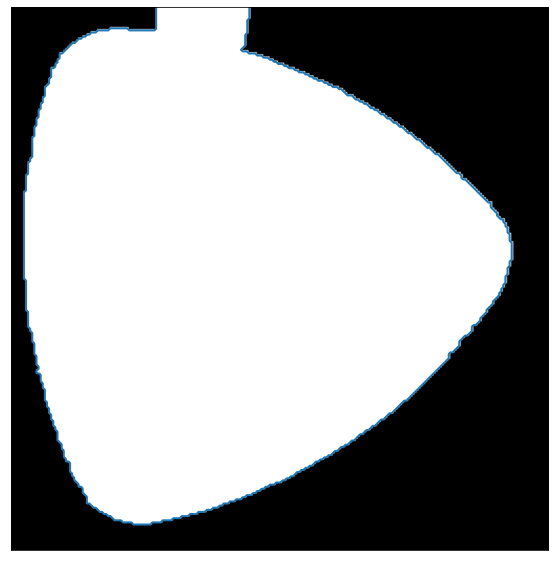

In [199]:
from skimage.color import label2rgb, rgb2gray
import matplotlib.patches as mpatches

label_image = label(out1)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

regions = regionprops(label_image)

print(len(regions))
minr, minc, maxr, maxc = regions[0].bbox

scale = 0.05

cropped = out1[minr-int(minr*scale):maxr+int(maxr*scale), minc-int(minc*scale):maxc+int(maxc*scale)]
cropped1 = out1[minr:maxr, minc:maxc]

from skimage import measure

contours = measure.find_contours(cropped, 0.8)

if len(contours) != 0:
    # Display the image and plot all contours found
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(cropped, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
       # ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        pass

    contours.sort(key=len)

    ax.plot(contours[-1][:,1], contours[-1][:,0], lw=2)

    coords = contours[-1]

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

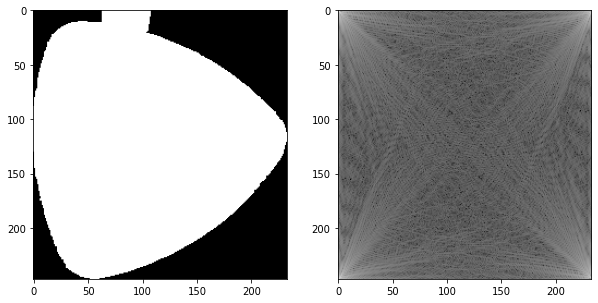

In [201]:
# Shape signature by fft

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2

Z = fft2(cropped1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(cropped1, cmap='gray')
ax[1].imshow(20*np.log10(abs(Z)), cmap='gray')


927
Number of coordinates: 927 8
metric: 0.7615453463221208


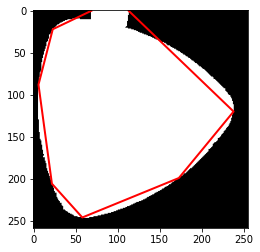

In [224]:
# approximate / simplify coordinates of the two ellipses

contour = contours[0]

fig, ax = plt.subplots(1,1, figsize=(9, 4))

ax.imshow(cropped, cmap='gray')

print(len(contour))

coords = measure.approximate_polygon(contour, tolerance=20)
ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
print("Number of coordinates:", len(contour), len(coords))

r = regions[0]

print('metric: {}'.format((4*np.pi*r.area)/r.perimeter**2))

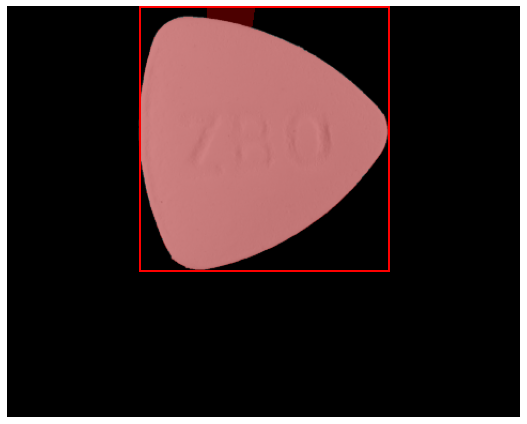

In [103]:
from skimage.color import label2rgb, rgb2gray
import matplotlib.patches as mpatches

# label image regions
label_image = label(out1)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

regions = regionprops(label_image)
for region in regions:
    # take regions with large enough areas
    if region.area >= 200:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

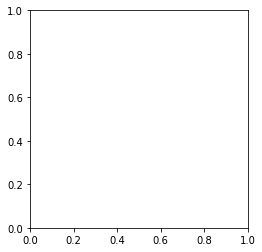

In [105]:
minr, minc, maxr, maxc = regions[0].bbox
sw = image_orig.shape[1] / image.shape[1]
sh = image_orig.shape[0] / image.shape[0]

minr *= sh
maxr *= sh
minc *= sw
maxc *= sw

plt.imshow(image_orig[int(minr):int(maxr), int(minc):int(maxc), :])
print(regions[0].bbox)

In [ ]:
import numpy as np
import cv2

# read an image with shadow...
# and it converts to BGR color space automatically
or_img = cv2.imread(os.path.join(images_dir, filename))

width = 480
height = int(or_img.shape[0] * (480 / or_img.shape[1]))
dim = (width, height)
# resize image
or_img = cv2.resize(or_img, dim, interpolation = cv2.INTER_AREA)
 
# covert the BGR image to an YCbCr image
y_cb_cr_img = cv2.cvtColor(or_img, cv2.COLOR_BGR2YCrCb)

# copy the image to create a binary mask later
binary_mask = np.copy(y_cb_cr_img)

# get mean value of the pixels in Y plane
y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

# get standard deviation of channel in Y plane
y_std = np.std(cv2.split(y_cb_cr_img)[0])

# classify pixels as shadow and non-shadow pixels
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):

        if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
            # paint it white (shadow)
            binary_mask[i, j] = [255, 255, 255]
        else:
            # paint it black (non-shadow)
            binary_mask[i, j] = [0, 0, 0]

# Using morphological operation
# The misclassified pixels are
# removed using dilation followed by erosion.
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(binary_mask, kernel, iterations=1)

# sum of pixel intensities in the lit areas
spi_la = 0

# sum of pixel intensities in the shadow
spi_s = 0

# number of pixels in the lit areas
n_la = 0

# number of pixels in the shadow
n_s = 0

# get sum of pixel intensities in the lit areas
# and sum of pixel intensities in the shadow
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
            spi_la = spi_la + y_cb_cr_img[i, j, 0]
            n_la += 1
        else:
            spi_s = spi_s + y_cb_cr_img[i, j, 0]
            n_s += 1

# get the average pixel intensities in the lit areas
average_ld = spi_la / n_la

# get the average pixel intensities in the shadow
average_le = spi_s / n_s

# difference of the pixel intensities in the shadow and lit areas
i_diff = average_ld - average_le

# get the ratio between average shadow pixels and average lit pixels
ratio_as_al = average_ld / average_le

# added these difference
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:

            y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,
                                 y_cb_cr_img[i, j, 2] + ratio_as_al]

# covert the YCbCr image to the BGR image
final_image = cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)

cv2.imshow("im1", or_img)
cv2.imshow("im2", final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()